In [1]:
import os

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

2023-10-16 15:19:23.127587: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-16 15:19:23.515701: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 15:19:25.430322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class DenseNN(tf.Module):
    def __init__(self, outputs, activate="relu"):
        super().__init__()
        self.outputs = outputs
        self.activate = activate
        self.fl_init = False

    def __call__(self, x):
        if not self.fl_init:
            self.w = tf.random.truncated_normal((x.shape[-1], self.outputs), stddev=0.1, name="w")
            self.b = tf.zeros([self.outputs], dtype=tf.float32, name="b")

            self.w = tf.Variable(self.w)
            self.b = tf.Variable(self.b)

            self.fl_init = True

        y = x @ self.w + self.b

        if self.activate == "relu":
            return tf.nn.relu(y)
        elif self.activate == "softmax":
            return tf.nn.softmax(y)

        return y

In [3]:
class Sm(tf.Module):
    def __init__(self):
        super().__init__()
        self.l_1 = DenseNN(128)
        self.l_2 = DenseNN(10, activate = 'softmax')
    def __call__(self, x):
        return self.l_2(self.l_1(x))
    


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

x_train = tf.reshape(tf.cast(x_train, tf.float32), [-1, 28*28])
x_test = tf.reshape(tf.cast(x_test, tf.float32), [-1, 28*28])

y_train = to_categorical(y_train, 10)

2023-10-16 15:19:42.795948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 15:19:43.146385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 15:19:43.146454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 15:19:43.180455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 15:19:43.180531: I tensorflow/compile

In [23]:
model = Sm()
print(model)

In [24]:
cross_entropy = lambda y_true, y_pred: tf.reduce_mean(tf.losses.categorical_crossentropy(y_true, y_pred))
opt = tf.optimizers.Adam(learning_rate=0.001)

In [25]:
BATCH_SIZE = 32
EPOCHS = 20
TOTAL = x_train.shape[0]

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [27]:
for n in range(EPOCHS):
    loss = 0

    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            f_loss = cross_entropy(y_batch, model(x_batch))

        loss += f_loss
        grads = tape.gradient(f_loss, model.trainable_variables)
        opt.build(model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))

    print(f'loss = {loss.numpy()}')

loss = 503.3775634765625
loss = 222.39439392089844
loss = 152.7122039794922
loss = 112.2451171875
loss = 87.28946685791016
loss = 66.24317169189453
loss = 51.58202362060547
loss = 40.854087829589844
loss = 33.673946380615234
loss = 27.639829635620117
loss = 23.12002182006836
loss = 22.661636352539062
loss = 17.314647674560547
loss = 15.803730964660645
loss = 12.719385147094727
loss = 13.536865234375
loss = 13.01051139831543
loss = 10.643952369689941
loss = 9.269742965698242
loss = 9.6825532913208


In [28]:
y = model(x_test)
y_pred = tf.argmax(y, axis=1).numpy()
acc = tf.metrics.Accuracy()
acc.update_state(y_test, y_pred)
print(f'Accuracy = {acc.result().numpy()*100}')

Accuracy = 98.03000092506409


In [29]:
def start_count(arr):
    result = np.zeros(10)
    for i in range(len(arr)):
        path = os.path.join('photos', arr[i])
        image = tf.keras.utils.load_img(path)
        image = tf.image.resize(image, (28, 28))
        image = tf.image.rgb_to_grayscale(image)
        image = tf.squeeze(image, axis=2)
        image = image.numpy()
        prediction = model(image.reshape(1, 28*28))
        prediction = tf.argmax(prediction, axis=1)
        result[int(prediction)-1]+=1
        if i%500==0:
            print(f'i = {i}, result = {result}')
    return result


In [33]:
arr = os.listdir('photos')
# len(arr)
result = start_count(arr)
print(f'result = {result}')
# result = [1537. 1142. 1470. 1367. 1196. 1097.  907.  854. 1196. 1234.] 10 epochs
# result = [1523. 1096. 1421. 1324. 1187. 1192.  885.  928. 1161. 1283.] 20 epochs

i = 0, result = [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
i = 500, result = [66. 40. 54. 62. 53. 52. 32. 41. 43. 58.]
i = 1000, result = [143.  83. 108. 108. 113. 105.  66.  72.  88. 115.]
i = 1500, result = [208. 131. 159. 161. 158. 158. 106. 110. 149. 161.]
i = 2000, result = [256. 183. 231. 217. 219. 208. 140. 145. 189. 213.]
i = 2500, result = [322. 226. 298. 263. 256. 258. 178. 191. 235. 274.]
i = 3000, result = [381. 272. 365. 315. 301. 308. 224. 233. 273. 329.]
i = 3500, result = [446. 317. 420. 370. 350. 359. 253. 276. 323. 387.]
i = 4000, result = [503. 356. 482. 427. 405. 423. 287. 315. 379. 424.]
i = 4500, result = [566. 400. 551. 488. 457. 465. 316. 344. 421. 493.]
i = 5000, result = [637. 449. 605. 540. 499. 519. 353. 382. 474. 543.]
i = 5500, result = [701. 502. 661. 596. 555. 564. 385. 427. 515. 595.]
i = 6000, result = [756. 535. 742. 661. 602. 611. 419. 454. 568. 653.]
i = 6500, result = [822. 590. 799. 723. 646. 659. 456. 490. 613. 703.]
i = 7000, result = [895. 637. 859. 768. 

In [12]:
import matplotlib.pyplot as plt
def show_image(x):
    image = tf.keras.utils.load_img(f'photos/{x}')
    image = tf.image.resize(image, (28, 28))
    image = tf.image.rgb_to_grayscale(image)
    image = tf.squeeze(image, axis=2)
    x = image.numpy()
    prediction = model(x.reshape(1, 28*28))
    print(np.argmax(prediction))
    plt.imshow(image, cmap='binary')
    # print(image.shape)    

2


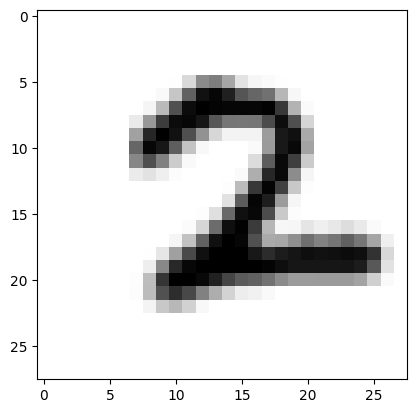

In [39]:
show_image(arr[99])

In [45]:
pred_test = model(x_test)
pred_test = np.argmax(pred_test, axis=1)

# print(pred_test.shape)

print(pred_test[:35])
print(np.argmax(y[:35], axis=1))

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7]


In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred=pred_test, y_true=y_test)

array([[ 971,    0,    2,    0,    0,    0,    4,    1,    1,    1],
       [   0, 1127,    2,    0,    0,    0,    2,    1,    3,    0],
       [   5,    1, 1014,    2,    1,    0,    3,    3,    3,    0],
       [   0,    0,    3,  986,    1,    6,    0,    5,    4,    5],
       [   2,    0,    3,    0,  963,    1,    3,    1,    1,    8],
       [   2,    0,    0,    7,    1,  874,    3,    0,    4,    1],
       [   4,    3,    4,    1,    2,    8,  935,    0,    1,    0],
       [   2,    4,   11,    0,    1,    0,    0, 1002,    1,    7],
       [   2,    1,    5,    4,    4,    6,    1,    4,  943,    4],
       [   3,    2,    2,    1,    6,    3,    0,    2,    2,  988]])